# Fussing with Full Resolution

In [1]:
# imports
import os
import glob
import xarray

import numpy as np
from scipy import stats
from scipy.interpolate import interp1d 

from gsw import conversions, density
import gsw

from matplotlib import pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator 

import seaborn as sns

import pandas

from ocpy.utils import plotting

from cugn import grid_utils
from cugn import utils as cugn_utils
from cugn import io as cugn_io
from cugn import annualcycle

# Load CUGN

In [2]:
line = '90.0'
#
items = cugn_io.load_up(line)#, gextrem='low')
grid_extrem = items[0]
ds = items[1]

Loading: doxy_grid_line90.parquet
Loading: doxy_grid_line90.parquet
Found 29 unique clusters


# Examine a Mission and a few of its Profiles

In [3]:
mname = '20503001'
in_grid = (grid_extrem.mission.values == mname)
np.unique(grid_extrem.mission_profile.values[in_grid])
profile = 972

In [4]:
idx = (grid_extrem.mission.values == mname) & (grid_extrem.mission_profile.values == profile)
np.sum(idx)
grid_extrem.MLD.values[idx]

array([6.08593589])

## Load up

In [6]:
high_path = os.path.join(os.getenv('OS_SPRAY'), 'CUGN', 'HighRes')
gfiles = glob.glob(os.path.join(high_path, f'SPRAY-FRSQ-{mname}-*.nc'))
hfile = gfiles[0]                   
#hfile
ds_high = xarray.open_dataset(hfile)
ds_high

<xarray.Dataset> Size: 203MB
Dimensions:                     (trajectory: 1, profile: 1004, obs: 1104091)
Coordinates:
  * trajectory                  (trajectory) |S19 19B b'sp030-20200513T1702'
  * profile                     (profile) float64 8kB 1.0 2.0 ... 1.004e+03
    time                        (profile) datetime64[ns] 8kB ...
    latitude                    (profile) float64 8kB ...
    latitude_uv                 (profile) float64 8kB ...
    longitude                   (profile) float64 8kB ...
    longitude_uv                (profile) float64 8kB ...
    time_uv                     (profile) datetime64[ns] 8kB ...
    depth                       (obs) float64 9MB ...
Dimensions without coordinates: obs
Data variables: (12/54)
    profile_obs_index           (obs) float64 9MB ...
    row_size                    (profile) int32 4kB ...
    time_qc                     (profile) float64 8kB ...
    latitude_qc                 (profile) float64 8kB ...
    latitude_uv_qc              (profile) float64 8kB ...
    longitude_qc                (profile) float64 8kB ...
    ...                          ...
    gps_end_qc_tests            (profile) float64 8kB ...
    wmo_id                      <U7 28B ...
    instrument_doxy             float64 8B ...
    instrument_ctd              float64 8B ...
    instrument_fchl             float64 8B ...
    platform_meta               float64 8B ...
Attributes: (12/65)
    Conventions:                   CF-1.8, COARDS, ACDD-1.3
    acknowledgement:               Funded by National Oceanic and Atmospheric...
    cdm_profile_variables:         profile,time,latitude,longitude
    cdm_trajectory_variables:      trajectory
    comment:                       This file contains data from the following...
    contributor_name:              Daniel Rudnick, Jennifer Sevadjian
    ...                            ...
    time_coverage_duration:        P0000-03-19T23:09:53
    time_coverage_end:             2020-09-02T16:12:26Z
    time_coverage_resolution:      P0000-00-00T00:00:04
    time_coverage_start:           2020-05-13T17:02:33Z
    title:                         Science Quality Full-Resolution Data from ...
    history:                       2020-09-14T16:18:20Z: KDZ readflasho63(gps...

In [17]:
my_obs = ds_high.profile_obs_index.values == profile
my_obs.size
my_obs += ds_high.depth.values > 0.5

<Axes: ylabel='Count'>

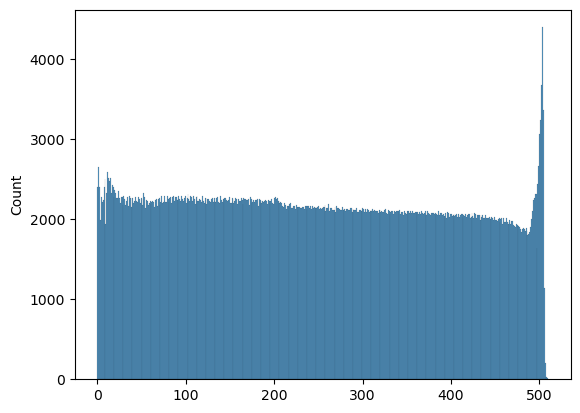

In [18]:
sns.histplot(ds_high.depth[my_obs].values, bins=500)